# Problem 2: Incorporating CNNs

* Learning Objective: In this problem, you will learn how to deeply understand how Convolutional Neural Networks work by implementing one.
* Provided Code: We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* TODOs: you will implement a Convolutional Layer and a MaxPooling Layer to improve on your classification results in part 1.

In [1]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.mlp.train import *
from lib.cnn.layer_utils import *
from lib.cnn.cnn_models import *
from lib.datasets import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading the data (CIFAR-100 with 20 superclasses)

In this homework, we will be classifying images from the CIFAR-100 dataset into the 20 superclasses. More information about the CIFAR-100 dataset and the 20 superclasses can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

Download the CIFAR-100 data files [here](https://drive.google.com/drive/folders/1imXxTnpkMbWEe41pkAGNt_JMTXECDSaW?usp=share_link), and save the `.mat` files to the `data/cifar100` directory.

In [2]:
data = CIFAR100_data('data/cifar100/')
for k, v in data.items():
    if type(v) == np.ndarray:
        print ("Name: {} Shape: {}, {}".format(k, v.shape, type(v)))
    else:
        print("{}: {}".format(k, v))
label_names = data['label_names']
mean_image = data['mean_image'][0]
std_image = data['std_image'][0]

Name: data_train Shape: (40000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_train Shape: (40000,), <class 'numpy.ndarray'>
Name: data_val Shape: (10000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_val Shape: (10000,), <class 'numpy.ndarray'>
Name: data_test Shape: (10000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_test Shape: (10000,), <class 'numpy.ndarray'>
label_names: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
Name: mean_image Shape: (1, 1, 1, 3), <class 'numpy.ndarray'>
Name: std_image Shape: (1, 1, 1, 3), <class 'numpy.ndarray'>


Label: large_omnivores_and_herbivores


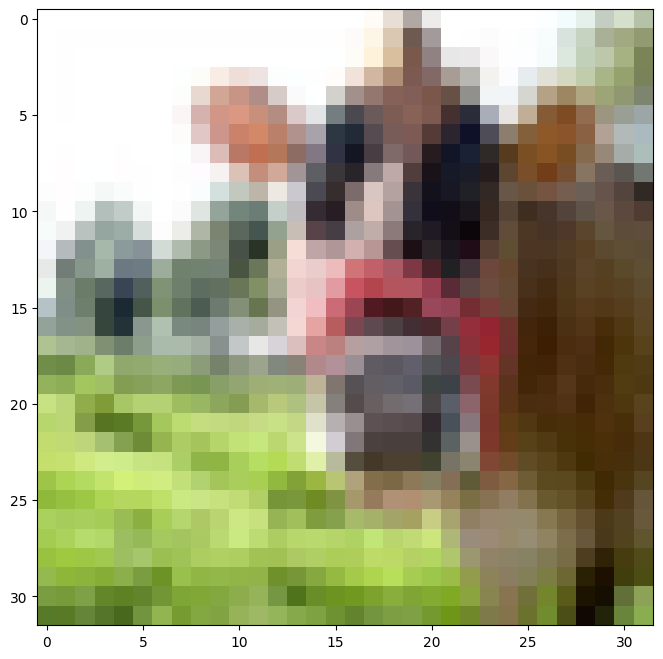

In [3]:
idx = 0
image_data = data['data_train'][idx]
image_data = ((image_data*std_image + mean_image) * 255).astype(np.int32)
plt.imshow(image_data)
label = label_names[data['labels_train'][idx]]
print("Label:", label)

## Convolutional Neural Networks

We will use convolutional neural networks to try to improve on the results from Problem 1. Convolutional layers make the assumption that local pixels are more important for prediction than far-away pixels. This allows us to form networks that are robust to small changes in positioning in images.

### Convolutional Layer Output size calculation [2pts]

As you have learned, two important parameters of a convolutional layer are its stride and padding. To warm up, we will need to calculate the output size of a convolutional layer given its stride and padding. To do this, open the `lib/cnn/layer_utils.py` file and fill out the TODO section in the `get_output_size` function in the ConvLayer2D class. 

Implement your function so that it returns the correct size as indicated by the block below.

In [4]:
%reload_ext autoreload

input_image = np.zeros([32, 28, 28, 3]) # a stack of 32 28 by 28 rgb images

in_channels = input_image.shape[-1] #must agree with the last dimension of the input image
k_size = 4 
n_filt = 16

conv_layer = ConvLayer2D(in_channels, k_size, n_filt, stride=2, padding=3)
output_size = conv_layer.get_output_size(input_image.shape) 

print("Received {} and expected [32, 16, 16, 16]".format(output_size))

Received (32, 16, 16, 16) and expected [32, 16, 16, 16]


### Convolutional Layer Forward Pass [5pts]

Now, we will implement the forward pass of a convolutional layer. Fill in the TODO block in the `forward` function of the ConvLayer2D class.

In [5]:
%reload_ext autoreload

# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=1*8*8*1).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image
in_channels, k_size, n_filt = 1, 5, 2

weight_size = k_size*k_size*in_channels*n_filt
bias_size = n_filt



single_conv = ConvLayer2D(in_channels, k_size, n_filt, stride=1, padding=0, name="conv_test")

w = np.linspace(-0.2, 0.2, num=weight_size).reshape(k_size, k_size, in_channels, n_filt)
b = np.linspace(-0.3, 0.3, num=bias_size)

single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

out = single_conv.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 4, 4, 2)".format(out.shape))

correct_out = np.array([[
   [[-0.03874312, 0.57000324],
   [-0.03955296, 0.57081309],
   [-0.04036281, 0.57162293],
   [-0.04117266, 0.57243278]],

  [[-0.0452219, 0.57648202],
   [-0.04603175, 0.57729187],
   [-0.04684159, 0.57810172],
   [-0.04765144, 0.57891156]],

  [[-0.05170068, 0.5829608 ],
   [-0.05251053, 0.58377065],
   [-0.05332038, 0.5845805 ],
   [-0.05413022, 0.58539035]],

  [[-0.05817946, 0.58943959],
   [-0.05898931, 0.59024943],
   [-0.05979916, 0.59105928],
   [-0.06060901, 0.59186913]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 4, 4, 2), Expected output shape: (1, 4, 4, 2)
Difference:  5.110565335399418e-08


### Conv Layer Backward [5pts]

Now complete the backward pass of a convolutional layer. Fill in the TODO block in the `backward` function of the ConvLayer2D class. Check you results with this code and expect differences of less than 1e-6.

In [6]:
%reload_ext autoreload

# Test the conv backward function
img = np.random.randn(15, 8, 8, 3)
w = np.random.randn(4, 4, 3, 12)
b = np.random.randn(12)
dout = np.random.randn(15, 4, 4, 12)

single_conv = ConvLayer2D(input_channels=3, kernel_size=4, number_filters=12, stride=2, padding=1, name="conv_test")
single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

dimg_num = eval_numerical_gradient_array(lambda x: single_conv.forward(img), img, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_conv.forward(img), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_conv.forward(img), b, dout)

out = single_conv.forward(img)

dimg = single_conv.backward(dout)
dw = single_conv.grads[single_conv.w_name]
db = single_conv.grads[single_conv.b_name]

# The error should be around 1e-6
print("dimg Error: ", rel_error(dimg_num, dimg))
# The errors should be around 1e-8
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  3.384972739206786e-08
dw Error:  2.811807681644842e-08
db Error:  3.103386251018093e-10
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


## Max pooling Layer
Now we will implement maxpooling layers, which can help to reduce the image size while preserving the overall structure of the image.

### Forward Pass max pooling [5pts]
Fill out the TODO block in the `forward` function of the MaxPoolingLayer class.

In [7]:
# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=64).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")
out = maxpool.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 3, 3, 1)".format(out.shape))

correct_out = np.array([[
   [[0.11428571],
   [0.13015873],
   [0.14603175]],

  [[0.24126984],
   [0.25714286],
   [0.27301587]],

  [[0.36825397],
   [0.38412698],
   [0.4       ]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 3, 3, 1), Expected output shape: (1, 3, 3, 1)
Difference:  1.8750000280978013e-08


### Backward Pass Max pooling [5pts]
Fill out the `backward` function in the MaxPoolingLayer class.

In [8]:
img = np.random.randn(15, 8, 8, 3)

dout = np.random.randn(15, 3, 3, 3)

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")

dimg_num = eval_numerical_gradient_array(lambda x: maxpool.forward(img), img, dout)

out = maxpool.forward(img)
dimg = maxpool.backward(dout)

# The error should be around 1e-8
print("dimg Error: ", rel_error(dimg_num, dimg))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  3.2759848189533932e-12
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


### Test a Small Convolutional Neural Network [3pts]
Please find the `TestCNN` class in `lib/cnn/cnn_models.py`.
Again you only need to complete few lines of code in the TODO block.
Please design a Convolutional --> Maxpool --> flatten --> fc network where the shapes of parameters match the given shapes.
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively.
Here you only modify the param_name part, the _w, and _b are automatically assigned during network setup.

In [9]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = TestCNN()
loss_func = cross_entropy()

B, H, W, iC = 4, 8, 8, 3 #batch, height, width, in_channels
k = 3 #kernel size
oC, Hi, O = 3, 27, 5 # out channels, Hidden Layer input, Output size
std = 0.02
x = np.random.randn(B,H,W,iC)
y = np.random.randint(O, size=B)

print ("Testing initialization ... ")

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
w1_std = abs(model.net.get_params("conv_w").std() - std)
b1 = model.net.get_params("conv_b").std()
w2_std = abs(model.net.get_params("fc_w").std() - std)
b2 = model.net.get_params("fc_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=k*k*iC*oC).reshape(k,k,iC,oC)
w2 = np.linspace(-0.2, 0.2, num=Hi*O).reshape(Hi, O)
b1 = np.linspace(-0.6, 0.2, num=oC)
b2 = np.linspace(-0.9, 0.1, num=O)

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
model.net.assign("conv_w", w1)
model.net.assign("conv_b", b1)
model.net.assign("fc_w", w2)
model.net.assign("fc_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=B*H*W*iC).reshape(B,H,W,iC)
scores = model.forward(feats)
correct_scores = np.asarray([[-13.85107294, -11.52845818,  -9.20584342,  -6.88322866,  -4.5606139 ],
 [-11.44514171, -10.21200524 , -8.97886878 , -7.74573231 , -6.51259584],
 [ -9.03921048,  -8.89555231 , -8.75189413 , -8.60823596,  -8.46457778],
 [ -6.63327925 , -7.57909937 , -8.52491949 , -9.4707396 , -10.41655972]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 2, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 4.56046848799693
assert abs(loss - correct_loss) < 1e-10, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
conv_b relative error: 3.90e-09
conv_w relative error: 9.74e-10
fc_b relative error: 8.77e-11
fc_w relative error: 3.83e-07


### Training the Network [25pts]
In this section, we defined a `SmallConvolutionalNetwork` class for you to fill in the TODO block in `lib/cnn/cnn_models.py`.

Here please design a network with at most two convolutions and two maxpooling layers (you may use less).
You can adjust the parameters for any layer, and include layers other than those listed above that you have implemented (such as fully-connected layers and non-linearities).
You are also free to select any optimizer you have implemented (with any learning rate).

You will train your network on CIFAR-100 20-way superclass classification.
Try to find a combination that is able to achieve 40% validation accuracy.

Since the CNN takes significantly longer to train than the fully connected network, it is suggested to start off with fewer filters in your Conv layers and fewer intermediate fully-connected layers so as to get faster initial results.

In [10]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [11]:
print("Data shape:", data_dict["data_train"][0].shape)
print("Flattened data input size:", np.prod(data["data_train"].shape[1:]))
print("Number of data classes:", max(data['labels_train']) + 1)

Data shape: (40000, 32, 32, 3)
Flattened data input size: 3072
Number of data classes: 20


In [14]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = SmallConvolutionalNetwork()
loss_f = cross_entropy()


results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
# You may only adjust the hyperparameters within this block                 #
#############################################################################
optimizer = Adam(model.net, 0.5e-3, weight_decay=1e-6)

batch_size = 128
epochs = 10
lr_decay = .999
lr_decay_every = 100
regularization = "l2"
reg_lambda = 1e-4
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs, 
                    lr_decay, lr_decay_every, show_every=312, verbose=True, regularization=regularization, reg_lambda=reg_lambda)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

  0%|          | 1/312 [00:01<07:16,  1.40s/it]

(Iteration 1 / 3120) Average loss: 2.9956182872517685


100%|██████████| 312/312 [06:41<00:00,  1.29s/it]


(Epoch 1 / 10) Training Accuracy: 0.30625, Validation Accuracy: 0.3003


  0%|          | 1/312 [00:01<08:47,  1.69s/it]

(Iteration 313 / 3120) Average loss: 2.5347842676540395


100%|██████████| 312/312 [06:39<00:00,  1.28s/it]


(Epoch 2 / 10) Training Accuracy: 0.3633, Validation Accuracy: 0.354


  0%|          | 1/312 [00:01<06:54,  1.33s/it]

(Iteration 625 / 3120) Average loss: 2.2193641693167057


100%|██████████| 312/312 [07:04<00:00,  1.36s/it]


(Epoch 3 / 10) Training Accuracy: 0.3929, Validation Accuracy: 0.3826


  0%|          | 1/312 [00:01<08:15,  1.59s/it]

(Iteration 937 / 3120) Average loss: 2.1016068221389728


 71%|███████▏  | 223/312 [05:13<02:00,  1.35s/it]/Users/dch239/Desktop/USC/Spring 2023/CSCI 566/csci566-assignment1/lib/mlp/layer_utils.py:242: RuntimeWarning: overflow encountered in power
  df = 0.5*(1 + np.tanh(temp)) + (feat / (np.sqrt(2*np.pi))) * (0.134145 * np.power(feat, 2) + 1) * (1 / (np.power(np.cosh(temp), 2)))
100%|██████████| 312/312 [07:17<00:00,  1.40s/it]


(Epoch 4 / 10) Training Accuracy: 0.41205, Validation Accuracy: 0.393


  0%|          | 1/312 [00:01<08:22,  1.61s/it]

(Iteration 1249 / 3120) Average loss: 2.0332600447299902


100%|██████████| 312/312 [07:34<00:00,  1.46s/it]


(Epoch 5 / 10) Training Accuracy: 0.4243, Validation Accuracy: 0.4063


  0%|          | 1/312 [00:01<09:00,  1.74s/it]

(Iteration 1561 / 3120) Average loss: 1.9797013122046627


100%|██████████| 312/312 [09:51<00:00,  1.90s/it]


(Epoch 6 / 10) Training Accuracy: 0.438425, Validation Accuracy: 0.4163


  0%|          | 1/312 [00:01<07:24,  1.43s/it]

(Iteration 1873 / 3120) Average loss: 1.93930080280749


100%|██████████| 312/312 [07:34<00:00,  1.46s/it]


(Epoch 7 / 10) Training Accuracy: 0.44795, Validation Accuracy: 0.4261


  0%|          | 1/312 [00:01<06:53,  1.33s/it]

(Iteration 2185 / 3120) Average loss: 1.902913832763841


100%|██████████| 312/312 [07:59<00:00,  1.54s/it]


(Epoch 8 / 10) Training Accuracy: 0.4611, Validation Accuracy: 0.4307


  0%|          | 1/312 [00:01<07:47,  1.50s/it]

(Iteration 2497 / 3120) Average loss: 1.8765245643042574


100%|██████████| 312/312 [07:54<00:00,  1.52s/it]


(Epoch 9 / 10) Training Accuracy: 0.465625, Validation Accuracy: 0.4381


  0%|          | 1/312 [00:01<07:33,  1.46s/it]

(Iteration 2809 / 3120) Average loss: 1.8496333748867215


100%|██████████| 312/312 [08:56<00:00,  1.72s/it]


(Epoch 10 / 10) Training Accuracy: 0.472925, Validation Accuracy: 0.4444


Run the code below to generate the training plots.

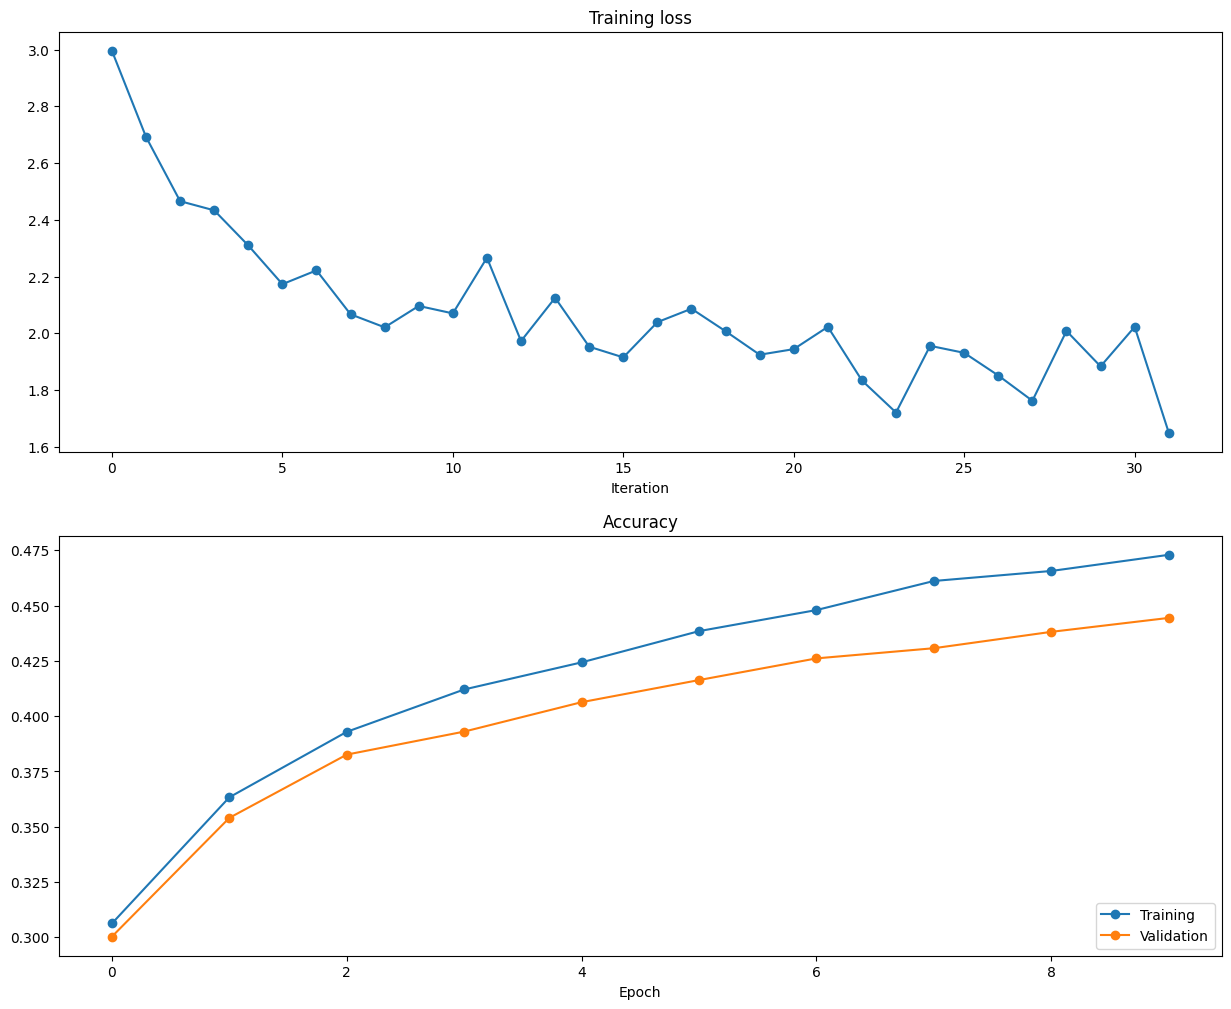

In [15]:
%reload_ext autoreload

opt_params, loss_hist, train_acc_hist, val_acc_hist = results

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

### Visualizing Layers [5pts]

An interesting finding from early research in convolutional networks was that the learned convolutions resembled filters used for things like edge detection. Complete the code below to visualize the filters in the first convolutional layer of your best model.

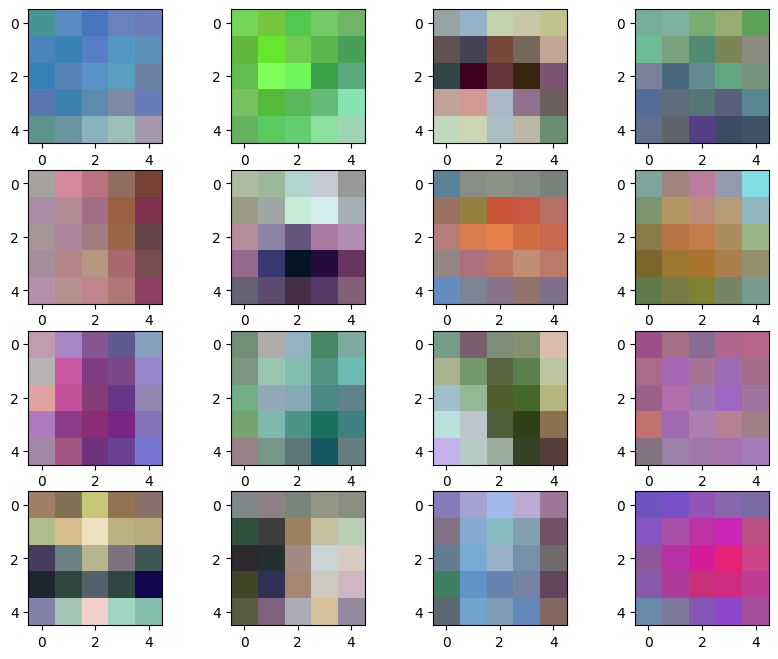

In [16]:
im_array = None
nrows, ncols = None, None

###################################################
# TODO: read the weights in the convolutional     #
# layer and reshape them to a grid of images to   #
# view with matplotlib.                           #
###################################################
# compute the number of rows and columns in the grid
filter_width, filter_height = 5, 5
aspect_ratio = filter_width / filter_height  # adjust this as needed
num_filters = 16
nrows = int(np.sqrt(num_filters / aspect_ratio))
ncols = int(np.ceil(num_filters / nrows))
weights = opt_params["conv1_w"]
# normalize weights between 0-1
weights -= weights.min()
weights /= (weights.max() - weights.min())

plt.figure()
for i in range(num_filters):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(weights[:,:,:,i])
plt.show()

###################################################
#                END OF YOUR CODE                 #
###################################################

# plt.imshow(im_array)

#### Inline Question: Comment below on what kinds of filters you see. Include your response in your submission [5pts]

Answer: In a CNN, the filters in a convolutional layer represent learned feature detectors that are used to identify specific patterns or structures in the input data. The filters are applied to small regions of the input data, and the output of the filter is passed to the next layer in the network. The filters are learned during the training process and are adjusted to minimize the loss function.

Since the filters are usually learned through the training process, the specific patterns or structures represented by each filter would depend on the task and the input data used for training. In general, the filters are expected to learn low-level features such as edges, corners, and blobs in the early layers of the network.

We cannot tell what the filters above have learned exactly, but they might represent something like the shape of the object or contrast between different colors in the image.

## Extra-Credit: Analysis on Trained Model [5pts]

For extra credit, you can perform some additional analysis of your trained model. Some suggested analyses are:
1. Plot the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of your model's predictions on the test set. Look for trends to see which classes are frequently misclassified as other classes (e.g. are the two vehicle superclasses frequently confused with each other?).
2. Implement [BatchNorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) and analyze how the models train with and without BatchNorm.
3. Introduce some small noise in the labels, and investigate how that affects training and validation accuracy.

You are free to choose any analysis question of interest to you. We will not be providing any starter code for the extra credit. Include your extra-credit analysis as the final section of your report pdf, titled "Extra Credit".

In [19]:
#CONFUSION MATRIX
from lib.mlp.train import get_preds

data_test, labels_test = data_dict["data_test"]
test_preds = get_preds(model, data_test, labels_test, batch_size=batch_size)
test_accuracy = np.mean(test_preds == labels_test)
print(f"Accuracy on test set = {test_accuracy}")

100%|██████████| 79/79 [00:37<00:00,  2.10it/s]

Accuracy on test set = 0.0688


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

n_samples = len(labels_test)
n_classes = 20
y_true = labels_test
y_pred = test_preds

# compute confusion matrix
cm = np.zeros((n_classes, n_classes), dtype=int)
for i in range(n_samples):
    cm[y_true[i], y_pred[i]] += 1

# plot confusion matrix
classes = [str(i) for i in range(n_classes)]
plot_confusion_matrix(cm, classes)
plt.show()

# Submission

Please prepare a PDF document `problem_2_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for CNN training
2. Visualization of convolutional filters
3. Answers to inline questions about convolutional filters

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.